<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-data" data-toc-modified-id="Make-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make data</a></span><ul class="toc-item"><li><span><a href="#Make-network" data-toc-modified-id="Make-network-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Make network</a></span><ul class="toc-item"><li><span><a href="#Make-cases" data-toc-modified-id="Make-cases-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Make cases</a></span></li></ul></li></ul></li><li><span><a href="#Compute-gradient" data-toc-modified-id="Compute-gradient-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compute gradient</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Tasks" data-toc-modified-id="Tasks-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Tasks</a></span></li></ul></li></ul></li><li><span><a href="#Comparing-jacobians" data-toc-modified-id="Comparing-jacobians-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparing jacobians</a></span></li></ul></div>

In [1]:
using Pkg; Pkg.activate()

using LinearAlgebra
using Distributions, Random
using LightGraphs
using Convex, ECOS
using Plots

using Revise
using CarbonNetworks

ECOS_QUIET = () -> ECOS.Optimizer(verbose=false)

┌ Info: Precompiling CarbonNetworks [d5dced0a-5569-40db-8865-1dbf132a76f2]
└ @ Base loading.jl:1317


#1 (generic function with 1 method)

# Make data

## Make network

In [4]:
Random.seed!(2)
n = 50

# Make graph
G = watts_strogatz(n, 4, 0.2)

# Convert to incidence matrix
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

# Generate costs
fq = rand(Exponential(5), n) .+ 2
fl = rand(Exponential(5), n) .+ 2

# Generate generation and flow capacities
gmax = rand(Gamma(5.0, 5.0), n)
pmax = rand(Gamma(1.0, 1.0), m)

B = I;

### Make cases

In [7]:
Random.seed!(3)

num_cases = 1_000

cases = []
for _ in 1:num_cases
    d = rand(Uniform(0.0, 1.05), n) .* gmax
    
    opf = PowerManagementProblem(fq, fl, d, pmax, gmax, A)
    solve!(opf, ECOS_QUIET)
    
    if Int(opf.problem.status) == 2
        continue
    end
        
    push!(cases, (d=d, g=evaluate(opf.g)))
end

In [8]:
train_cases = cases[1:400]
test_cases = cases[401:end];

# Compute gradient

We want to solve 

$$\text{minimize}_f\quad \| g^*(d_t; f) - g_{\mathrm{true}}(d_t) \|_2^2$$ %+ \frac{\lambda}{2} \| f \|_2^2$$
    
where $L(g) = \frac{1}{2} \| g - g_{\mathrm{true}} \|_2^2$ and $g^*(f)$ is the OPF mapping. This gradient of the loss is $\nabla L(g) = g - g_{\mathrm{true}}$.

### Tasks

- [ ] Speed up algorithm via warm starting
- [ ] Tune regularization parameters
- [ ] Verify that LMPs are similar to true LMPs (since that is what matters)

In [50]:
# Algorithm parameters
step_length = 10.0
max_iter = 250
batch_size = 1
test_batch_size = 4

4

In [55]:
Random.seed!(123)

# Initialize estimated costs
f̂q = rand(Exponential(5), n) .+ 2
f̂l = rand(Exponential(5), n) .+ 2


train_loss_hist = []
test_loss_hist = []
grad_hist = []
acc_hist = []

Any[]

In [63]:
Random.seed!(12345)

@time for iter in 1:max_iter
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, dfq, dfl = stochastic_loss_and_grad(f̂q, f̂l, B, train_cases, pmax, gmax, A, sample)
    
    push!(train_loss_hist, L)
    push!(grad_hist, dfq)
    push!(acc_hist, abs(f̂q'fq) / (norm(f̂q) * norm(fq)) + abs(f̂l'fl) / (norm(f̂l) * norm(fl)))
    
    # Compute test loss
    sample = rand(1:length(test_cases), test_batch_size)
    L_test, _, _ = stochastic_loss_and_grad(f̂q, f̂l, B, test_cases, pmax, gmax, A, sample)
    push!(test_loss_hist, L_test)
    
    # Take projected gradient step - quadratic term
    η = (norm(dfq) > step_length) ? step_length : norm(dfq)
    f̂q = max.(f̂q - η*dfq/norm(dfq), 2)
    
    # Take projected gradient step - linear term
    η = (norm(dfl) > step_length) ? step_length : norm(dfl)
    f̂l = max.(f̂q - η*dfl/norm(dfl), 2)
end
println("Completed $(max_iter) iterations.")

  9.450253 seconds (16.43 M allocations: 3.126 GiB, 4.77% gc time)
Completed 250 iterations.


best_test_loss = 0.023179317101740905
gen_size = 99.19529845471891
sqrt(best_test_loss / gen_size) = 0.015286384322336302


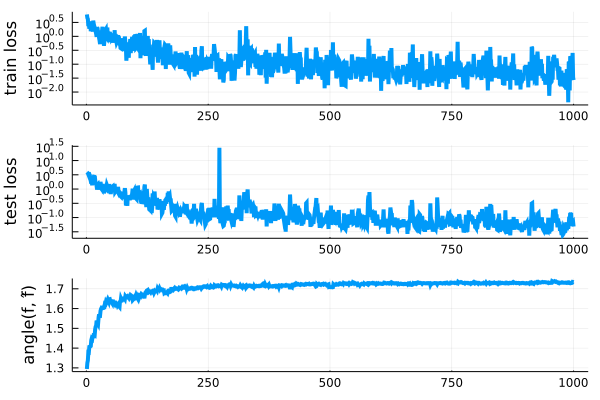

In [64]:
### best = x -> [minimum(x[1:k]) for k in 1:length(x)]

best_test_loss = minimum(test_loss_hist)
gen_size = mean([(1/2) * norm(case.g)^2 for case in test_cases]) / n

@show best_test_loss
@show gen_size
@show sqrt(best_test_loss / gen_size)


theme(:default, lw=4, label=nothing)

plot(
    plot(train_loss_hist, ylabel="train loss", yscale=:log10),
    plot(test_loss_hist, ylabel="test loss", yscale=:log10),
    plot(acc_hist, ylabel="angle(f, f̂)"),
    layout=(3, 1)
)

norm(example_case.g - ĝ) / norm(example_case.g) = 0.03508415381563268


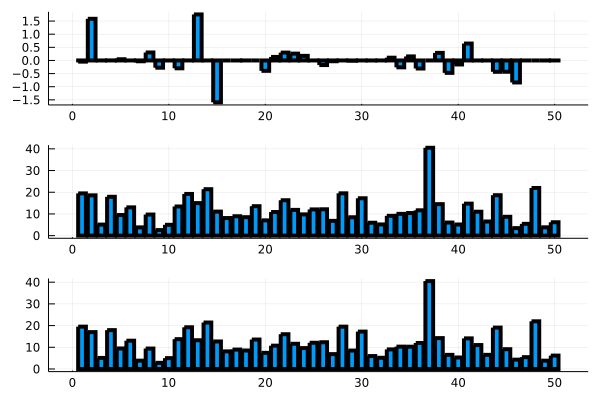

In [65]:
example_case = test_cases[6]

ĝ, opf, params = CarbonNetworks.solvePMP(f̂q, fl, example_case, pmax, gmax, A)

@show norm(example_case.g - ĝ) / norm(example_case.g)

plot(
    bar(example_case.g - ĝ),
    bar(example_case.g),
    bar(ĝ),
    layout=(3, 1)
)

sum(f̂q) = 1022.246958136853
sum(fq) = 293.2319736492847


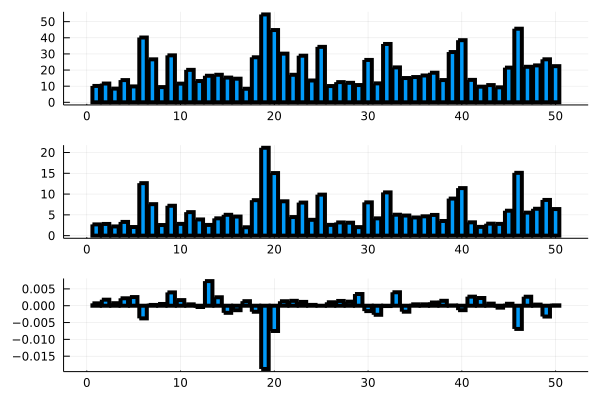

In [69]:
@show sum(f̂q)
@show sum(fq)

plot(bar(f̂q), bar(fq), bar(f̂q / sum(f̂q) - fq / sum(fq)), layout=(3, 1))
#plot(bar(f̂l), bar(fl), bar(f̂l / sum(f̂l) - fl / sum(fl)), layout=(3, 1))